In [2]:
from qiskit import IBMQ
import mitiq
from qiskit import QuantumCircuit, execute, Aer
import qiskit
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-france',group='univ-montpellier',project='default')

/home/siyuan/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


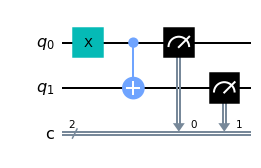

In [3]:
qc = QuantumCircuit(2,2)
qc.x(0)
qc.cx(0,1)
qc.measure(range(2),range(2))
qc.draw(output='mpl')

In [9]:
def sydney_executor(circuit: QuantumCircuit, shots: int=8192) -> float:
    job = execute(
        experiments=circuit,
        backend = provider.get_backend('ibmq_sydney'),
        optimization_level=0,
        shots=shots
    )
    counts = job.result().get_counts()
    if counts.get('1 1') is None:
        expectation_value = 0
    else:
        expectation_value = counts.get('1 1') / shots
    return expectation_value

# Using ZNE provided by Mitiq
x q[0];<br/>
x q[0];<br/>
x q[0];<br/>
cx q[0], q[1];<br/>
cx q[0], q[1];<br/>
cx q[0], q[1];<br/>
measure q[1] -> m_c_1[0];<br/>
measure q[0] -> m_c_0[0];<br/>

In [10]:
mitigated = mitiq.execute_with_zne(qc, sydney_executor)

In [11]:
print(mitigated)

0.8394775390624993


# Without ZNE with optimization level 0

In [14]:
job2 = execute(
    experiments=qc,
    backend = provider.get_backend('ibmq_sydney'),
    optimization_level=0,
    shots=8192
)

In [18]:
counts_without_mitiq = job2.result().get_counts()
expectation_value2 = counts_without_mitiq.get('11') / 8192

In [19]:
print("Without mitiq the expectation result is:", expectation_value2)

Without mitiq the expectation result is: 0.8382568359375


# Without ZNE with optimization level 3

In [20]:
job3 = execute(
    experiments=qc,
    backend = provider.get_backend('ibmq_sydney'),
    optimization_level=3,
    shots=8192
)

In [21]:
counts_without_mitiq = job3.result().get_counts()
expectation_value3 = counts_without_mitiq.get('11') / 8192

In [22]:
print("Expectation result is:", expectation_value3)

Expectation result is: 0.8382568359375


# Low level

In [24]:
scale_factors = [1., 1.5, 2., 2.5, 3.]
folded_circuits = [
        mitiq.zne.scaling.fold_gates_at_random(qc, scale)
        for scale in scale_factors
]
print("circuit number is:", len(folded_circuits))

circuit number is: 5


In [26]:
shots = 8192
backend_name = "ibmq_sydney"

job = qiskit.execute(
   experiments=folded_circuits,
   backend=provider.get_backend(backend_name), 
   optimization_level=0,  # Important!
   shots=shots
)

In [28]:
all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = [counts.get("1 1") / shots for counts in all_counts]

In [38]:
print("Unmitigated expectation value:", round(expectation_values[0], 3))

Unmitigated expectation value: 0.772


In [48]:
fac = mitiq.zne.inference.LinearFactory


In [49]:
zero_noise_value = fac.extrapolate(scale_factors, expectation_values)

In [50]:
zero_noise_value

0.7836669921874999

In [52]:
fac2 = mitiq.zne.inference.RichardsonFactory

In [53]:
zero_noise_value2 = fac2.extrapolate(scale_factors, expectation_values)

In [54]:
zero_noise_value2

0.7961425781250214

In [55]:
fac3 = mitiq.zne.inference.PolyExpFactory

In [58]:
zero_noise_value3 = fac3.extrapolate(scale_factors, expectation_values, 2)

In [59]:
zero_noise_value3

0.7618156163143234